## Import Libraries

In [3]:
import requests
import json
import pandas as pd
import numpy as np
import time
import random
import matplotlib.cm as cm
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
#pd.set_option("display.max_rows", 10)

## Set constant variables

In [2]:
base_url = 'https://csgostats.gg/'
leaderboards_url = 'https://csgostats.gg/leaderboards'

## Get list of ranks and the urls for each rank leaderboard.

### Using Requests (can't scrape due to captcha)

In [3]:
result = requests.get(leaderboards_url)
soup = BeautifulSoup(result.text, 'html.parser')
soup

<!DOCTYPE html>

<!--[if lt IE 7]> <html class="no-js ie6 oldie" lang="en-US"> <![endif]-->
<!--[if IE 7]>    <html class="no-js ie7 oldie" lang="en-US"> <![endif]-->
<!--[if IE 8]>    <html class="no-js ie8 oldie" lang="en-US"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-US"> <!--<![endif]-->
<head>
<title>Attention Required! | Cloudflare</title>
<meta charset="utf-8"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
<meta content="noindex, nofollow" name="robots"/>
<meta content="width=device-width,initial-scale=1" name="viewport"/>
<link href="/cdn-cgi/styles/cf.errors.css" id="cf_styles-css" rel="stylesheet"/>
<!--[if lt IE 9]><link rel="stylesheet" id='cf_styles-ie-css' href="/cdn-cgi/styles/cf.errors.ie.css" /><![endif]-->
<style>body{margin:0;padding:0}</style>
<!--[if gte IE 10]><!-->
<script>
  if (!navigator.cookieEnabled) {
    window.addEventListener('DOMContentLoaded', function

### Using selenium (success)

In [8]:
username = 'chris'

# webdriver options
chromeOptions = Options()
# chromeOptions.add_argument('--kiosk')                          # sets the headless browser into full screen mode
# chromeOptions.add_argument('--headless')                       # opens the browser silently (hides it, if you enable this, make sure to disable kiosk)
chromeOptions.add_argument('--log-level=3')                    # stops the headless browser's logging features
# chromeOptions.add_argument('blink-settings=imagesEnabled=false') # set loading images to be false (for faster loading)
chromeOptions.add_argument('--no-sandbox')                     # required when running as root user. otherwise you would get no sandbox errors. 
chromeOptions.add_argument('--disable-extensions')
chromeOptions.add_argument('--disable-gpu')
chromeOptions.page_load_strategy = 'eager'

# to prevent getting a captcha, make it look like that the bot is a human
chromeOptions.add_argument("--profile-directory=Default")
chromeOptions.add_argument("--user-data-dir=C:/Users/%s/AppData/Local/Google/Chrome/User Data" % username)
chromeOptions.add_argument('--disable-blink-features=AutomationControlled')

chromeOptions.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36")

# Run the Driver
driver = webdriver.Chrome('./chromedriver/chromedriver.exe', options=chromeOptions, service_args=['--verbose'])

C:\Users\chris\AppData\Local\Temp\ipykernel_2248\2506721761.py:22: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver/chromedriver.exe', options=chromeOptions, service_args=['--verbose'])


In [ ]:
# Close the driver
driver.close()

In [95]:
# Get the list of ranks and the corresponding leaderboards in that rank
ranks = {
    'Rank': [],
    'URL': [],
}

# Go to Leaderboards page
driver.get(leaderboards_url)

# Loop the competitive rank images
for li in driver.find_elements_by_tag_name('ul')[5].find_elements_by_tag_name('li'):
    rank_name = li.find_element_by_tag_name('img').get_attribute('alt')
    rank_url = li.find_element_by_tag_name('a').get_attribute('href')
    
    print(rank_name, '|', rank_url)
    
    ranks['Rank'].append(rank_name)
    ranks['URL'].append(rank_url)

C:\Users\chris\AppData\Local\Temp\ipykernel_18444\1731053946.py:6: DeprecationWarning: find_elements_by_tag_name is deprecated. Please use find_elements(by=By.TAG_NAME, value=name) instead
  for li in driver.find_elements_by_tag_name('ul')[5].find_elements_by_tag_name('li'):
C:\Users\chris\AppData\Local\Temp\ipykernel_18444\1731053946.py:7: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  rank_name = li.find_element_by_tag_name('img').get_attribute('alt')
C:\Users\chris\AppData\Local\Temp\ipykernel_18444\1731053946.py:8: DeprecationWarning: find_element_by_tag_name is deprecated. Please use find_element(by=By.TAG_NAME, value=name) instead
  rank_url = li.find_element_by_tag_name('a').get_attribute('href')


Silver I | https://csgostats.gg/leaderboards/1
Silver II | https://csgostats.gg/leaderboards/2
Silver III | https://csgostats.gg/leaderboards/3
Silver IV | https://csgostats.gg/leaderboards/4
Silver Elite | https://csgostats.gg/leaderboards/5
Silver Elite Master | https://csgostats.gg/leaderboards/6
Gold Nova I | https://csgostats.gg/leaderboards/7
Gold Nova II | https://csgostats.gg/leaderboards/8
Gold Nova III | https://csgostats.gg/leaderboards/9
Gold Nova Master | https://csgostats.gg/leaderboards/10
Master Guardian I | https://csgostats.gg/leaderboards/11
Master Guardian II | https://csgostats.gg/leaderboards/12
Master Guardian Elite | https://csgostats.gg/leaderboards/13
Distinguished Master Guardian | https://csgostats.gg/leaderboards/14
Legendary Eagle | https://csgostats.gg/leaderboards/15
Legendary Eagle Master | https://csgostats.gg/leaderboards/16
Supreme Master First Class | https://csgostats.gg/leaderboards/17
The Global Elite | https://csgostats.gg/leaderboards/18


In [96]:
ranks_df = pd.DataFrame(ranks)
ranks_df.head()

,Rank,URL
0,Silver I,https://csgostats.gg/leaderboards/1
1,Silver II,https://csgostats.gg/leaderboards/2
2,Silver III,https://csgostats.gg/leaderboards/3
3,Silver IV,https://csgostats.gg/leaderboards/4
4,Silver Elite,https://csgostats.gg/leaderboards/5


In [98]:
ranks_df.to_json('ranks.json', orient='records')

## Get all the players and their stats for each rank

### Scraping Timeframe: 
1. 06/16/22 5PM to 06/16/22 8PM. 
2. 06/17/2022 7:30AM to 06/17/2022 8:30AM.

In [3]:
ranks_df = pd.read_json('ranks.json')
ranks_df.head()

,Rank,URL
0,Silver I,https://csgostats.gg/leaderboards/1
1,Silver II,https://csgostats.gg/leaderboards/2
2,Silver III,https://csgostats.gg/leaderboards/3
3,Silver IV,https://csgostats.gg/leaderboards/4
4,Silver Elite,https://csgostats.gg/leaderboards/5


In [4]:
players_data = {
    'Competitive Rank': [],
    'Leaderboards Rank': [],
    'Username': [],
    'Primary Weapon': [],
    'Secondary Weapon': [],
    'K/D Score': [],
    'K/D Ratio': [],
    'HS %': [],
    'Win Rate': [],
    '1vX': [],
    'Rating': []
}

for _, data in list(ranks_df.iterrows())[14:]:
    page = 1
    print(data['Rank'])
    while(True):
        # Get the URL passing the page query
        driver.get(data['URL'] + ('?page=%d' % page))
        
        # Pass the html source of the result to beautiful soup
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        
        # Get all the players using class global-lb and recursive=False
        players = soup.find('div', class_='global-lb').find_all('div', recursive=False)[3].find_all('div', recursive=False)[:-1]
        print('Page %d: %d players' % (page, len(players)))
        
        if(len(players) == 0):
            break
        
        for div in players:
            # Get all top layer divs 
            # Note: there are no classes or ids that could select each players
            divs = div.find_all('div', recursive=False)
            if(len(divs) > 0): # if 
                rank = divs[0].text.strip().replace('#', '')
                username = divs[1].text.strip()
                primary = divs[2].find('img').get('title')
                secondary = divs[3].find('img').get('title')
                kd_score, kd_ratio = divs[4].text.strip().split('\n')
                hs_percent = divs[5].text.strip()
                win_rate = divs[6].text.strip()
                onevx = divs[7].text.strip()
                rating = divs[8].text.strip()

                players_data['Competitive Rank'].append(data['Rank'])
                players_data['Leaderboards Rank'].append(rank)
                players_data['Username'].append(username)
                players_data['Primary Weapon'].append(primary)
                players_data['Secondary Weapon'].append(secondary)
                players_data['K/D Score'].append(kd_score)
                players_data['K/D Ratio'].append(kd_ratio)
                players_data['HS %'].append(hs_percent)
                players_data['Win Rate'].append(win_rate)
                players_data['1vX'].append(onevx)
                players_data['Rating'].append(rating)

                # print('[', rank, ']', username, '|', primary, '|', secondary, '|', kd_score, '|', kd_ratio, '|', hs_percent, '|', win_rate, '|', onevx, '|', rating)
        
        page += 1
        
        # Add random delay to prevent excessive page request
        time.sleep(random.random() * 0.75 + 0.5)

Legendary Eagle


NameError: name 'driver' is not defined

In [10]:
players_df = pd.DataFrame(players_data)
players_df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Legendary Eagle,1,千ㄥ乇乂,ssg08,mp9,5.54,388 / 70,56%,90%,6,4.17
1,Legendary Eagle,2,törkeä raiskaus,ssg08,usp_silencer,11.79,283 / 24,81%,90%,5,3.74
2,Legendary Eagle,3,WHY YOU NO WIN,ssg08,revolver,4.18,251 / 60,75%,80%,2,3
3,Legendary Eagle,4,☯,ak47,awp,6.37,312 / 49,28%,90%,18,2.98
4,Legendary Eagle,5,Heisenberg,ak47,m4a1_silencer,3.56,224 / 63,81%,80%,6,2.9


In [11]:
len(players_df)

96434

In [12]:
players_df.to_json('le-tge_players.json', orient='records', indent=4)

In [13]:
players_df = pd.read_json('le-tge_players.json')
players_df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Legendary Eagle,1,千ㄥ乇乂,ssg08,mp9,5.54,388 / 70,56%,90%,6,4.17
1,Legendary Eagle,2,törkeä raiskaus,ssg08,usp_silencer,11.79,283 / 24,81%,90%,5,3.74
2,Legendary Eagle,3,WHY YOU NO WIN,ssg08,revolver,4.18,251 / 60,75%,80%,2,3.00
3,Legendary Eagle,4,☯,ak47,awp,6.37,312 / 49,28%,90%,18,2.98
4,Legendary Eagle,5,Heisenberg,ak47,m4a1_silencer,3.56,224 / 63,81%,80%,6,2.90


## Combining all the files
From the scraping, we seperated the files since some failures occur, so we save the progress to a json file. Now we have to combine all the files so get all the players.

In [2]:
json_files = [
    'silver1_players.json',
    'silver2_players.json',
    'silver3_players.json',
    's4-mg2_players.json',
    'mg2_players.json',
    'mge-le_players.json',
    'le-tge_players.json'
]

dfs = []

for file in json_files:
    dfs.append(pd.read_json('./initial_data/' + file))
    
df = pd.concat(dfs, axis=0)
len(df)

NameError: name 'pd' is not defined

### Remove duplicate values
To get the duplicated values, we create a new column named `Unique` which contains the `Competitive Rank` and `Leaderboards Rank`. This works since `Leaderboards Rank` should only occur once in each `Competitive Rank`

In [86]:
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,195 / 29,33%,90%,12,2.75
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,277 / 129,65%,80%,11,2.10
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,227 / 96,59%,10%,2,1.99
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,228 / 132,52%,50%,11,1.98
4,Silver I,5,The Honse,ak47,revolver,1.92,265 / 138,52%,60%,7,1.97


In [87]:
# Create a "Unique" column
df['Unique'] = df.apply(lambda x: x['Competitive Rank'] + ' ' + str(x['Leaderboards Rank']), axis=1)
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating,Unique
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,195 / 29,33%,90%,12,2.75,Silver I 1
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,277 / 129,65%,80%,11,2.10,Silver I 2
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,227 / 96,59%,10%,2,1.99,Silver I 3
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,228 / 132,52%,50%,11,1.98,Silver I 4
4,Silver I,5,The Honse,ak47,revolver,1.92,265 / 138,52%,60%,7,1.97,Silver I 5


As can be seen, the original values were 517738, and when we get the unique values it became 481792. This shows that there are duplicated values.

In [88]:
print(len(df), len(df['Unique'].unique()))

517738 481792


Remove Duplicates

In [89]:
df = df.drop_duplicates(['Unique'])
len(df)

481792

In [90]:
# Remove column
del df['Unique']
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,K/D Ratio,HS %,Win Rate,1vX,Rating
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,195 / 29,33%,90%,12,2.75
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,277 / 129,65%,80%,11,2.10
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,227 / 96,59%,10%,2,1.99
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,228 / 132,52%,50%,11,1.98
4,Silver I,5,The Honse,ak47,revolver,1.92,265 / 138,52%,60%,7,1.97


In [91]:
# Save df to json
df.to_json('./data/players.json', orient='records', indent=4)

## Data Preprocessing

In [4]:
df = pd.read_json('./data/players.json')
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,33,90,12,2.75,195,29
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,65,80,11,2.10,277,129
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,59,10,2,1.99,227,96
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,52,50,11,1.98,228,132
4,Silver I,5,The Honse,ak47,revolver,1.92,52,60,7,1.97,265,138


### Convert `HS %` into Integer

In [93]:
df['HS %'] = df['HS %'].apply(lambda x: x.replace('%', '')).astype(int)

### Convert `Win Rate` into Integer

In [94]:
df['Win Rate'] = df['Win Rate'].apply(lambda x: x.replace('%', '')).astype(int)

### Create column for `Kills`

In [95]:
df['Kills'] = df['K/D Ratio'].apply(lambda x: x.split(' / ')[0]).astype(int)

### Create column for `Deaths`

In [96]:
df['Deaths'] = df['K/D Ratio'].apply(lambda x: x.split(' / ')[1]).astype(int)

### Remove `K/D Ratio` column

In [97]:
del df['K/D Ratio']
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,33,90,12,2.75,195,29
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,65,80,11,2.10,277,129
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,59,10,2,1.99,227,96
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,52,50,11,1.98,228,132
4,Silver I,5,The Honse,ak47,revolver,1.92,52,60,7,1.97,265,138


### Replace Nulls and blank values with "None"

In [101]:
df.fillna("None", inplace = True)
df.isnull().sum()
df.loc[df['Primary Weapon'].eq(""),'Primary Weapon'] = 'None'
df.loc[df['Secondary Weapon'].eq(""),'Secondary Weapon'] = 'None'

### Merge Knife weapons into One knife category

In CSGO, The knives are a singular weapon with no performance difference no matter what the skin is so all knife entries would be changed to "knife"

In [23]:
df['Primary Weapon'].value_counts()

ak47                 319315
awp                   68482
m4a1_silencer         57470
p90                    6694
m4a1                   3365
deagle                 3078
sg556                  2977
aug                    2959
ssg08                  2931
mp7                    2601
negev                  1836
galilar                1677
bizon                  1350
xm1014                 1270
mp9                    1107
mac10                  1028
mp5sd                   785
famas                   403
ump45                   357
revolver                317
None                    285
usp_silencer            250
mag7                    245
nova                    201
scar20                  138
glock                   131
p250                     93
elite                    80
tec9                     79
g3sg1                    67
sawedoff                 64
hkp2000                  31
fiveseven                27
taser                    23
m4a1_silencer_off        23
cz75a               

In [24]:
df['Secondary Weapon'].value_counts()

m4a1_silencer        148840
ak47                 106127
awp                   91885
m4a1                  57402
deagle                18617
p90                    6650
aug                    5710
mp9                    5468
ssg08                  5349
sg556                  4649
galilar                3852
mac10                  3642
mp7                    3501
usp_silencer           3401
famas                  2929
glock                  1911
negev                  1831
xm1014                 1580
bizon                  1482
mp5sd                  1148
ump45                   885
p250                    816
mag7                    659
revolver                587
tec9                    458
scar20                  337
elite                   327
nova                    310
None                    308
hkp2000                 287
fiveseven               227
g3sg1                   162
m4a1_silencer_off       125
sawedoff                 99
taser                    84
cz75a               

In [102]:
#Locates an entry within the dataframe under column 'Primary Weapon' that matches the regex and changes entry to 'knife'
df.loc[df['Primary Weapon'].str.contains(r'(?i)knife'),'Primary Weapon'] = 'knife'
df['Primary Weapon'].value_counts()

ak47                 319315
awp                   68482
m4a1_silencer         57470
p90                    6694
m4a1                   3365
deagle                 3078
sg556                  2977
aug                    2959
ssg08                  2931
mp7                    2601
negev                  1836
galilar                1677
bizon                  1350
xm1014                 1270
mp9                    1107
mac10                  1028
mp5sd                   785
famas                   403
ump45                   357
revolver                317
None                    285
usp_silencer            250
mag7                    245
nova                    201
scar20                  138
glock                   131
p250                     93
elite                    80
tec9                     79
g3sg1                    67
sawedoff                 64
hkp2000                  31
fiveseven                27
taser                    23
m4a1_silencer_off        23
cz75a               

It can be seen from the value_counts() function that multiple knife weapons instances are in both the primary weapon and secondary weapon columns so those knife weapon instances would all be renamed to just "knife"

In [103]:
#Locates an entry within the dataframe under column 'Primary Weapon' that matches the regex and changes the entry to 'knife'
df.loc[df['Secondary Weapon'].str.contains(r'(?i)knife'),'Secondary Weapon'] = 'knife'
df.loc[df['Secondary Weapon'].str.contains(r'(?i)bayonet'),'Secondary Weapon'] = 'knife'
df['Secondary Weapon'].value_counts()

m4a1_silencer        148840
ak47                 106127
awp                   91885
m4a1                  57402
deagle                18617
p90                    6650
aug                    5710
mp9                    5468
ssg08                  5349
sg556                  4649
galilar                3852
mac10                  3642
mp7                    3501
usp_silencer           3401
famas                  2929
glock                  1911
negev                  1831
xm1014                 1580
bizon                  1482
mp5sd                  1148
ump45                   885
p250                    816
mag7                    659
revolver                587
tec9                    458
scar20                  337
elite                   327
nova                    310
None                    308
hkp2000                 287
fiveseven               227
g3sg1                   162
m4a1_silencer_off       125
sawedoff                 99
taser                    84
cz75a               

In [104]:
# Save df to json
df.to_json('./data/players.json', orient='records', indent=4)

## Exploratory Data Analysis

Reading the scraped data from .json.

In [5]:
df = pd.read_json('./data/players.json')
df.head()

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
0,Silver I,1,Chosen 1,m4a1_silencer,ak47,6.72,33,90,12,2.75,195,29
1,Silver I,2,David Hasslehof's Hairy Nuts,ssg08,ak47,2.15,65,80,11,2.10,277,129
2,Silver I,3,樱岛麻衣,ak47,deagle,2.36,59,10,2,1.99,227,96
3,Silver I,4,AdolfPootler,ak47,deagle,1.73,52,50,11,1.98,228,132
4,Silver I,5,The Honse,ak47,revolver,1.92,52,60,7,1.97,265,138


Reviewing shape of scraped data, after feature engineering.

In [6]:
df.shape

(481792, 12)

Viewing the different data types of each column of data: It can be seen that most of the stats recorded in the website are made up of numbers (floats and integers), with a few strings for *Competitive Rank*, *Username*, and their most used weapons in-game.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481792 entries, 0 to 481791
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Competitive Rank   481792 non-null  object 
 1   Leaderboards Rank  481792 non-null  int64  
 2   Username           481792 non-null  object 
 3   Primary Weapon     481792 non-null  object 
 4   Secondary Weapon   481792 non-null  object 
 5   K/D Score          481792 non-null  float64
 6   HS %               481792 non-null  int64  
 7   Win Rate           481792 non-null  int64  
 8   1vX                481792 non-null  int64  
 9   Rating             481792 non-null  float64
 10  Kills              481792 non-null  int64  
 11  Deaths             481792 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 44.1+ MB


Descriptive statistics of the scraped data

In [8]:
df.describe()

,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
count,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000,481792.000000
mean,18757.933714,1.013394,38.183341,45.649035,4.572322,1.000669,165.000745,165.769135
std,13614.756154,0.310852,9.064786,17.407108,2.805125,0.244459,46.199131,32.142983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7507.000000,0.830000,32.000000,30.000000,3.000000,0.840000,135.000000,152.000000
50%,15952.000000,0.980000,38.000000,50.000000,4.000000,0.980000,166.000000,173.000000
75%,27955.000000,1.160000,44.000000,60.000000,6.000000,1.140000,195.000000,188.000000
max,54675.000000,28.330000,93.000000,100.000000,30.000000,4.990000,485.000000,254.000000


Looking at the statistics generated, we can notice unusual 0 values in every column. Let's explore each column and explain these anomalies.

First is the *Leaderboards Rank*. This is assigned to players in the leaderboard after having been given a *Rating* (will be discuss later). Each division (Silver I, Silver II, etc.) has their own leaderboards.

The *Leaderboards Rank* should only be greater than or equal to 1 (1 being the top ranking player in that division's leaderboard). Descriptive statistics show that there is an entry with a 0 LR.

In [9]:
df.loc[df['Leaderboards Rank'] == 0]

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
154988,Gold Nova Master,0,Dash,ak47,m4a1_silencer,1.09,49,50,3,1.08,163,149


This occurance was observed, and has worsened, after initially scraping the website. In visiting the website now, some rank divisions do not have *Leaderboard Ranks* asssigned to the players in their respective lists. Thankfully, this unknown error has not greatly affected the scraped data that we have.

Next, we explore the *K/D Score*, *Kills*, and *Deaths*. *Kills* pertain to enemy takedowns in-game and *Deaths* amounts to the number of times a player dies in a match. The *K/D Score* is computed by dividing the amount of kills per death (Kills / Deaths).

Some players that made it into the leaderboards have a *K/D Score* of 0 or 0 in the *Kills* column. This implies that these players have not gotten in-game kills in their past 10 or more games, as per the minimum requirement of games played for appearing in the leaderboards.

In [10]:
df.loc[df['K/D Score'] == 0]

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
1111,Silver I,1199,.#TrueGaming l Gotya,None,None,0.0,0,0,0,0.61,0,10
1410,Silver I,1507,wtf,None,None,0.0,0,50,0,0.53,0,10
1623,Silver I,1731,好想被萝卜小姐超市啊,None,None,0.0,0,30,0,0.44,0,14
1670,Silver I,1780,sayonara,None,None,0.0,0,50,0,0.41,0,10
1672,Silver I,1782,𝒄𝒂𝒍,None,None,0.0,0,50,0,0.41,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
481787,The Global Elite,10053,retro,None,None,0.0,0,40,0,0.36,0,17
481788,The Global Elite,10054,K3Ty patinetY †,None,None,0.0,0,0,0,0.33,0,10
481789,The Global Elite,10055,qeety,None,None,0.0,0,40,0,0.33,0,18
481790,The Global Elite,10056,Jungle G,None,None,0.0,0,40,0,0.33,0,18


Conversely, the players with 0 in the *Deaths* column have not died in a match for their past 10 or more games.

In [9]:
df.loc[df['Deaths'] == 0]

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
41562,Silver IV,13580,鬼,None,None,0.0,0,30,0,0.00,0,0
102131,Gold Nova I,24015,0,ak47,glock,6.0,8,50,1,0.22,6,0
102135,Gold Nova I,24019,like a pussy get wet nigga,None,None,0.0,0,40,0,0.00,0,0
154986,Gold Nova III,32737,5204 / 5204 / 5204,awp,usp_silencer,6.0,2,60,0,0.16,6,0
186879,Gold Nova Master,36564,( ° ͜ʖ͡°)Ɑ͞ ̶͞ ̶͞ ̶͞ ﻝﮞ,None,None,0.0,0,40,0,0.00,0,0
218570,Master Guardian I,31714,COBRA KAI,p90,tec9,8.0,5,100,0,0.93,8,0
229161,Master Guardian I,42322,-ZUHN-1337-,None,None,0.0,0,100,0,0.82,0,0
278723,Master Guardian II,39277,Amogus,knife,usp_silencer,1.0,0,10,0,0.87,1,0
332348,Master Guardian Elite,42144,CAMBULA,None,None,0.0,0,100,0,0.82,0,0
341210,Master Guardian Elite,51794,✪ pestko;^),None,None,0.0,0,40,0,0.00,0,0


*HS %* is the percentage of kills that were made via headshot (shooting an enemy in the head). Having 0 in the *HS %* column would mean that the player has not had a kill that ended in a headshot.

In [10]:
df.loc[df['HS %'] == 0]

,Competitive Rank,Leaderboards Rank,Username,Primary Weapon,Secondary Weapon,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
1111,Silver I,1199,.#TrueGaming l Gotya,None,None,0.00,0,0,0,0.61,0,10
1410,Silver I,1507,wtf,None,None,0.00,0,50,0,0.53,0,10
1623,Silver I,1731,好想被萝卜小姐超市啊,None,None,0.00,0,30,0,0.44,0,14
1670,Silver I,1780,sayonara,None,None,0.00,0,50,0,0.41,0,10
1672,Silver I,1782,𝒄𝒂𝒍,None,None,0.00,0,50,0,0.41,0,10
1673,Silver I,1783,animelover69,None,None,0.00,0,50,0,0.41,0,10
1674,Silver I,1784,crush,None,None,0.00,0,50,0,0.41,0,10
1678,Silver I,1788,𝒄𝒂𝒍,None,None,0.00,0,50,0,0.41,0,10
1679,Silver I,1789,04Nov,None,None,0.00,0,50,0,0.41,0,10
1680,Silver I,1790,26yrs,None,None,0.00,0,50,0,0.41,0,10


*Win Rate* pertains to the win-to-loss ratio computed from the player's past 10 or more games. Having a *Win Rate* of 0 would mean that the player has not won matches for their past 10 or more games.

In [ ]:
df.loc[df['Win Rate'] == 0]

*1vX* is a count of how many 1-versus-X situations has the player won in their past 10 games. This tracks their wins in clutch situations (1v1s, 1v2s, ..., 1v5s)

In [ ]:
df[['Username', '1vX']]

*Rating* is the computed performance rating of the player, overall. This is computed using the following stats:
- kills per round
- rounds survived
- rounds with multiple kills

This is compared to the global average of the mentioned values.

A higher *Rating* would mean the player had an active and positive contribution to their team in their recent games. This is also the metric of which the leaderboard ranks each player in their respective divisions.

In [ ]:
df[['Username', '1vX']]

The remaining columns are *Competitive Rank*, *Username*, *Primary* and *Secondary Weapon*:

- *Competitive Rank* - in-game rank
- *Username* - display name of the player uses in-game, as of scraping
- *Primary* - most used weapon
- *Secondary* - second most used weapon

## Answering Questions:

### What is the average K/D, 1vx, and Rating per Competitive Rank?

In [16]:
df.groupby('Competitive Rank')[['K/D Score', 'Kills', 'Deaths', 'HS %', 'Win Rate', '1vX', 'Rating']].mean().sort_values('Rating', ascending=False)

,K/D Score,Kills,Deaths,HS %,Win Rate,1vX,Rating
Competitive Rank,,,,,,,
The Global Elite,1.315104,188.839515,152.014617,43.197474,63.917669,4.960624,1.213471
Supreme Master First Class,1.114175,175.611949,161.881324,41.909220,50.661509,4.591103,1.082548
Legendary Eagle Master,1.075519,183.289817,174.191299,41.017555,47.976131,4.880500,1.047462
Legendary Eagle,1.046198,167.368527,163.075935,40.642701,47.036110,4.434419,1.031125
Distinguished Master Guardian,1.040527,165.621098,162.099465,40.047162,46.286640,4.451570,1.026465
Master Guardian Elite,1.032603,163.247085,161.059581,39.240026,45.836257,4.424295,1.019631
Master Guardian II,1.021895,160.963344,160.251935,38.582745,44.915694,4.431751,1.011502
Master Guardian I,1.009787,158.059694,159.298767,38.131141,44.805229,4.389580,1.000773
Gold Nova Master,1.000760,176.386700,178.773775,37.150702,45.717955,5.004573,0.990907


### What is the most used primary and secondary weapon?

In [17]:
df['Primary Weapon'].value_counts()

ak47                 319315
awp                   68482
m4a1_silencer         57470
p90                    6694
m4a1                   3365
deagle                 3078
sg556                  2977
aug                    2959
ssg08                  2931
mp7                    2601
negev                  1836
galilar                1677
bizon                  1350
xm1014                 1270
mp9                    1107
mac10                  1028
mp5sd                   785
famas                   403
ump45                   357
revolver                317
None                    285
usp_silencer            250
mag7                    245
nova                    201
scar20                  138
glock                   131
p250                     93
elite                    80
tec9                     79
g3sg1                    67
sawedoff                 64
hkp2000                  31
fiveseven                27
taser                    23
m4a1_silencer_off        23
cz75a               

In [18]:
df['Secondary Weapon'].value_counts()

m4a1_silencer        148840
ak47                 106127
awp                   91885
m4a1                  57402
deagle                18617
p90                    6650
aug                    5710
mp9                    5468
ssg08                  5349
sg556                  4649
galilar                3852
mac10                  3642
mp7                    3501
usp_silencer           3401
famas                  2929
glock                  1911
negev                  1831
xm1014                 1580
bizon                  1482
mp5sd                  1148
ump45                   885
p250                    816
mag7                    659
revolver                587
tec9                    458
scar20                  337
elite                   327
nova                    310
None                    308
hkp2000                 287
fiveseven               227
g3sg1                   162
m4a1_silencer_off       125
sawedoff                 99
taser                    84
cz75a               

In [19]:
df[['Primary Weapon', 'Secondary Weapon']].value_counts()

Primary Weapon     Secondary Weapon 
ak47               m4a1_silencer        137653
                   awp                   81013
                   m4a1                  55588
m4a1_silencer      ak47                  46483
awp                ak47                  46411
ak47               deagle                14917
awp                m4a1_silencer          7691
m4a1_silencer      awp                    5154
ak47               mp9                    4047
                   p90                    3246
                   aug                    3067
awp                deagle                 3005
m4a1               ak47                   2567
ak47               ssg08                  2442
                   famas                  2397
awp                ssg08                  2319
p90                ak47                   2155
ak47               mac10                  2153
                   usp_silencer           1946
                   mp7                    1797
                   gali

### What is the distribution of players in each rank?

In [20]:
df['Competitive Rank'].value_counts()

Master Guardian I                53858
Master Guardian II               52843
Master Guardian Elite            47599
Distinguished Master Guardian    44146
Legendary Eagle                  37137
Gold Nova Master                 31924
Gold Nova III                    26658
Gold Nova II                     26193
Legendary Eagle Master           25975
Gold Nova I                      23459
Supreme Master First Class       23265
Silver Elite Master              20122
Silver Elite                     16992
Silver III                       14468
Silver IV                        12799
Silver II                        12436
The Global Elite                 10057
Silver I                          1861
Name: Competitive Rank, dtype: int64

<AxesSubplot:>

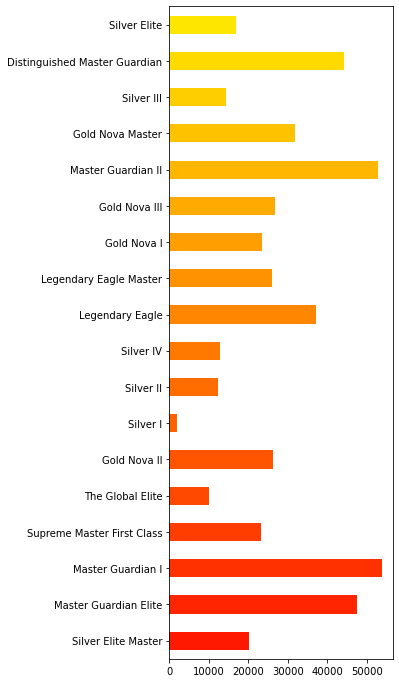

In [15]:
#Get the color map for the colors of autumn
cmap = cm.get_cmap('autumn')
#assigns the colors from the color map to an individual rank
colors = cmap(np.linspace(0.1, 0.9, df['Competitive Rank'].nunique()))
#Aggregate the players per rank and display as a horizontal bar graph
playerDistr =df['Competitive Rank'].value_counts(sort = False)
playerDistr.plot.barh(color=colors, figsize = (4,12))

# Data Analysis
- Performance of players in higher ranks is better
- Most well performing players use a specific set of weapons
- Win rate should be generally the same, maybe a bit higher in higher ranks

In [11]:
kd_over_5 = df[df['K/D Score'] > 5].groupby('Competitive Rank').size().reset_index(name='count')
kd_over_5

,Competitive Rank,count
0,Distinguished Master Guardian,4
1,Gold Nova I,2
2,Gold Nova II,1
3,Gold Nova III,2
4,Gold Nova Master,3
5,Legendary Eagle,6
6,Legendary Eagle Master,13
7,Master Guardian Elite,5
8,Master Guardian I,6
9,Master Guardian II,4


In [93]:
rank_order = ['Silver I', 'Silver II', 'Silver III', 'Silver IV', 'Silver Elite',
       'Silver Elite Master', 'Gold Nova I', 'Gold Nova II',
       'Gold Nova III', 'Gold Nova Master', 'Master Guardian I',
       'Master Guardian II', 'Master Guardian Elite',
       'Distinguished Master Guardian', 'Legendary Eagle',
       'Legendary Eagle Master', 'Supreme Master First Class',
       'The Global Elite']

# Insert zeroes for missing values
# TODO: Find way to do automatically
for i in rank_order:
    if((i in df['Competitive Rank']) == False):
        kd_over_5.loc[len(kd_over_5)] = [i, 0]

# Custom sorting
kd_over_5['Competitive Rank'] = pd.Categorical(kd_over_5['Competitive Rank'], rank_order)
kd_over_5.sort_values('Competitive Rank', inplace=True)

matplotlib.axes._subplots.AxesSubplot

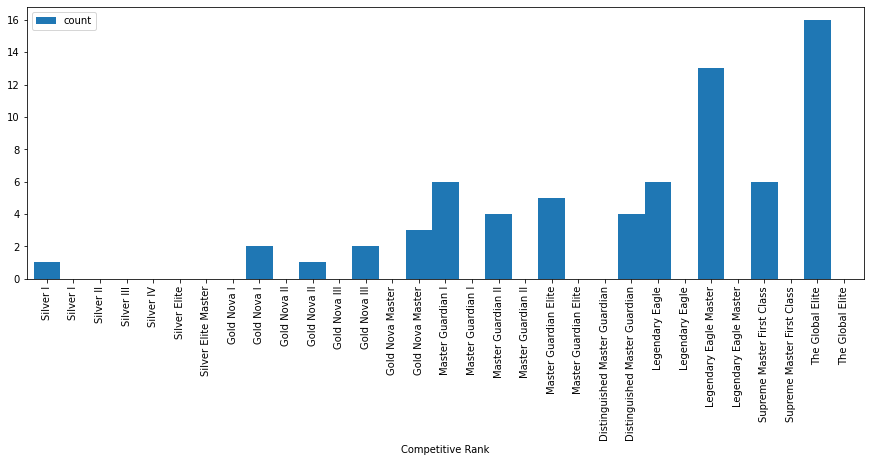

In [13]:
ax = kd_over_5.plot.bar(x='Competitive Rank', y='count', figsize=(15, 5), stacked=True, width=1)
type(ax)

# Correlation

In [72]:
df = pd.read_json('./data/players.json')

In [225]:
from sklearn import preprocessing
test = df
ranks = rank_order
ranks.reverse()
le = preprocessing.LabelEncoder()
le.classes_ = ranks
le.classes_

['The Global Elite',
 'Supreme Master First Class',
 'Legendary Eagle Master',
 'Legendary Eagle',
 'Distinguished Master Guardian',
 'Master Guardian Elite',
 'Master Guardian II',
 'Master Guardian I',
 'Gold Nova Master',
 'Gold Nova III',
 'Gold Nova II',
 'Gold Nova I',
 'Silver Elite Master',
 'Silver Elite',
 'Silver IV',
 'Silver III',
 'Silver II',
 'Silver I']

In [226]:
test['Encoded Competitive Rank'] = le.transform(test['Competitive Rank'])
test['Encoded Competitive Rank'] = test['Encoded Competitive Rank'] + 1
test
corr2 = test.corr(method = "spearman")
display(corr2)

,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths,Encoded Competitive Rank
Leaderboards Rank,1.000000,-0.730831,-0.047860,-0.281595,-0.332324,-0.749954,-0.558217,0.232591,-0.248656
K/D Score,-0.730831,1.000000,0.169242,0.388887,0.431916,0.974585,0.731714,-0.330514,-0.194346
HS %,-0.047860,0.169242,1.000000,0.046855,-0.001821,0.182634,0.116128,-0.051457,-0.255528
Win Rate,-0.281595,0.388887,0.046855,1.000000,0.137223,0.375160,0.227530,-0.257231,-0.135480
1vX,-0.332324,0.431916,-0.001821,0.137223,1.000000,0.415467,0.469121,0.013829,-0.010881
Rating,-0.749954,0.974585,0.182634,0.375160,0.415467,1.000000,0.745762,-0.274236,-0.194441
Kills,-0.558217,0.731714,0.116128,0.227530,0.469121,0.745762,1.000000,0.298875,-0.135112
Deaths,0.232591,-0.330514,-0.051457,-0.257231,0.013829,-0.274236,0.298875,1.000000,0.066697
Encoded Competitive Rank,-0.248656,-0.194346,-0.255528,-0.135480,-0.010881,-0.194441,-0.135112,0.066697,1.000000


In [228]:
test2 = df
test2 = test2.groupby('Competitive Rank').mean()
test2.drop(columns='Leaderboards Rank', inplace=True)

test2['Encoded Competitive Rank'] = le.transform(test2.index)
test2['Encoded Competitive Rank'] = test2['Encoded Competitive Rank'] + 1
test2.sort_values('Encoded Competitive Rank', ascending=False, inplace=True)
corr3 = test2.corr(method = "spearman")
display(corr3)

,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths,Encoded Competitive Rank
K/D Score,1.000000,0.991744,0.981424,0.261094,1.000000,0.591331,-0.005160,-0.991744
HS %,0.991744,1.000000,0.977296,0.236326,0.991744,0.587203,0.019608,-1.000000
Win Rate,0.981424,0.977296,1.000000,0.341589,0.981424,0.680083,0.085655,-0.977296
1vX,0.261094,0.236326,0.341589,1.000000,0.261094,0.853457,0.706914,-0.236326
Rating,1.000000,0.991744,0.981424,0.261094,1.000000,0.591331,-0.005160,-0.991744
Kills,0.591331,0.587203,0.680083,0.853457,0.591331,1.000000,0.543860,-0.587203
Deaths,-0.005160,0.019608,0.085655,0.706914,-0.005160,0.543860,1.000000,-0.019608
Encoded Competitive Rank,-0.991744,-1.000000,-0.977296,-0.236326,-0.991744,-0.587203,-0.019608,1.000000


In [210]:
ttest1 = test[test['Encoded Competitive Rank'] == 1]
ttest1 = ttest1.drop(columns=['Competitive Rank', 'Leaderboards Rank',
                              'Username', 'Primary Weapon', 'Secondary Weapon',
                              'Encoded Competitive Rank'])

ttest2 = test[test['Encoded Competitive Rank'] == 5]
ttest2 = ttest2.drop(columns=['Competitive Rank', 'Leaderboards Rank',
                              'Username', 'Primary Weapon', 'Secondary Weapon',
                              'Encoded Competitive Rank'])

In [237]:
test2

,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths,Encoded Competitive Rank
Competitive Rank,,,,,,,,
Silver I,0.684960,31.081677,30.956475,2.550779,0.703423,86.758732,127.065556,18
Silver II,0.825345,33.070843,37.692184,3.185108,0.836529,108.435912,133.485606,17
Silver III,0.889529,34.606165,39.445673,3.461639,0.897780,119.155654,136.352156,16
Silver IV,0.928585,34.614657,43.417454,4.808891,0.928385,164.224314,179.089382,15
Silver Elite,0.960028,35.044845,43.892420,4.927966,0.956016,168.886711,178.245410,14
Silver Elite Master,0.979748,35.712305,44.774376,5.016748,0.972375,171.884654,177.942004,13
Gold Nova I,0.976011,36.018628,44.507865,4.959845,0.967888,171.396436,178.300183,12
Gold Nova II,0.972012,36.209445,44.522201,4.896957,0.965631,171.674646,179.218264,11
Gold Nova III,0.983293,36.675107,44.935479,4.951084,0.975295,173.367920,178.767649,10


In [219]:
from scipy import stats
print(test2.iloc[0].name, ' ',
    test2.iloc[17].name, ' '
     )

rows = ['t-statistic', 'p-value']
cols = ['K/D Score', 'HS %', 'Win Rate', '1vX', 'Rating', 'Kills', 'Deaths',]
pd.DataFrame(stats.ttest_ind(ttest1, ttest2, equal_var=True), index=rows, columns=cols)

The Global Elite   Silver I  


,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
t-statistic,70.501878,3.210495e+01,89.614268,1.630957e+01,66.92443,45.000092,-2.662541e+01
p-value,0.000000,4.795686e-224,0.000000,1.171084e-59,0.00000,0.000000,3.455304e-155


In [218]:
pd.DataFrame(stats.ttest_ind(ttest1, ttest2, equal_var=False), index=rows, columns=cols)

,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
t-statistic,49.746766,3.027760e+01,83.836514,1.492457e+01,56.544917,43.015976,-2.533513e+01
p-value,0.000000,3.722958e-195,0.000000,5.627420e-50,0.000000,0.000000,1.513960e-138


In [214]:
df.groupby('Competitive Rank')[['K/D Score', 'Kills', 'Deaths', 'HS %', 'Win Rate', '1vX', 'Rating']].mean().sort_values('Rating', ascending=False)

,K/D Score,Kills,Deaths,HS %,Win Rate,1vX,Rating
Competitive Rank,,,,,,,
The Global Elite,1.315104,188.839515,152.014617,43.197474,63.917669,4.960624,1.213471
Supreme Master First Class,1.114175,175.611949,161.881324,41.909220,50.661509,4.591103,1.082548
Legendary Eagle Master,1.075519,183.289817,174.191299,41.017555,47.976131,4.880500,1.047462
Legendary Eagle,1.046198,167.368527,163.075935,40.642701,47.036110,4.434419,1.031125
Distinguished Master Guardian,1.040527,165.621098,162.099465,40.047162,46.286640,4.451570,1.026465
Master Guardian Elite,1.032603,163.247085,161.059581,39.240026,45.836257,4.424295,1.019631
Master Guardian II,1.021895,160.963344,160.251935,38.582745,44.915694,4.431751,1.011502
Master Guardian I,1.009787,158.059694,159.298767,38.131141,44.805229,4.389580,1.000773
Gold Nova Master,1.000760,176.386700,178.773775,37.150702,45.717955,5.004573,0.990907


In [23]:
for rank in rank_order:
    print(rank)
    corr = df[df['Competitive Rank'] == rank].corr(method = "spearman")
    display(corr)
print('Generalized')
corr = df.corr(method = "spearman")
display(corr)

Silver I


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.969000,-0.148985,-0.263692,-0.472990,-0.999893,-0.774241,0.077018
K/D Score,-0.969000,1.000000,0.131286,0.234270,0.464745,0.969192,0.778838,-0.090007
HS %,-0.148985,0.131286,1.000000,-0.009429,0.040550,0.149293,0.129272,0.071652
Win Rate,-0.263692,0.234270,-0.009429,1.000000,0.125608,0.263539,0.162745,-0.097986
1vX,-0.472990,0.464745,0.040550,0.125608,1.000000,0.472696,0.551066,0.237700
Rating,-0.999893,0.969192,0.149293,0.263539,0.472696,1.000000,0.774328,-0.077025
Kills,-0.774241,0.778838,0.129272,0.162745,0.551066,0.774328,1.000000,0.492362
Deaths,0.077018,-0.090007,0.071652,-0.097986,0.237700,-0.077025,0.492362,1.000000


Silver II


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.973049,-0.098165,-0.329326,-0.435443,-0.999914,-0.680115,0.180015
K/D Score,-0.973049,1.000000,0.082763,0.321195,0.440556,0.973096,0.680838,-0.203595
HS %,-0.098165,0.082763,1.000000,-0.008085,-0.013730,0.098248,0.044685,-0.030478
Win Rate,-0.329326,0.321195,-0.008085,1.000000,0.140179,0.329269,0.183464,-0.137822
1vX,-0.435443,0.440556,-0.013730,0.140179,1.000000,0.435434,0.518880,0.190205
Rating,-0.999914,0.973096,0.098248,0.329269,0.435434,1.000000,0.680148,-0.180037
Kills,-0.680115,0.680838,0.044685,0.183464,0.518880,0.680148,1.000000,0.538243
Deaths,0.180015,-0.203595,-0.030478,-0.137822,0.190205,-0.180037,0.538243,1.000000


Silver III


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.974941,-0.104193,-0.315591,-0.416265,-0.999913,-0.617076,0.209659
K/D Score,-0.974941,1.000000,0.096016,0.314656,0.427192,0.975014,0.620063,-0.230117
HS %,-0.104193,0.096016,1.000000,-0.034343,-0.022482,0.104262,0.027885,-0.058722
Win Rate,-0.315591,0.314656,-0.034343,1.000000,0.126136,0.315471,0.163007,-0.138157
1vX,-0.416265,0.427192,-0.022482,0.126136,1.000000,0.416376,0.519332,0.200027
Rating,-0.999913,0.975014,0.104262,0.315471,0.416376,1.000000,0.617119,-0.209690
Kills,-0.617076,0.620063,0.027885,0.163007,0.519332,0.617119,1.000000,0.584532
Deaths,0.209659,-0.230117,-0.058722,-0.138157,0.200027,-0.209690,0.584532,1.000000


Silver IV


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.972913,-0.092407,-0.287142,-0.474342,-0.999893,-0.919170,0.336598
K/D Score,-0.972913,1.000000,0.080437,0.291020,0.489812,0.972970,0.897573,-0.425643
HS %,-0.092407,0.080437,1.000000,-0.041451,-0.004733,0.092322,0.104239,0.034371
Win Rate,-0.287142,0.291020,-0.041451,1.000000,0.109476,0.287154,0.167986,-0.338771
1vX,-0.474342,0.489812,-0.004733,0.109476,1.000000,0.474243,0.444018,-0.224185
Rating,-0.999893,0.972970,0.092322,0.287154,0.474243,1.000000,0.919223,-0.336564
Kills,-0.919170,0.897573,0.104239,0.167986,0.444018,0.919223,1.000000,-0.033251
Deaths,0.336598,-0.425643,0.034371,-0.338771,-0.224185,-0.336564,-0.033251,1.000000


Silver Elite


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.972397,-0.123726,-0.311532,-0.470002,-0.999899,-0.913901,0.336457
K/D Score,-0.972397,1.000000,0.108123,0.317829,0.483752,0.972486,0.888275,-0.427823
HS %,-0.123726,0.108123,1.000000,0.011485,0.004730,0.123628,0.139415,0.032127
Win Rate,-0.311532,0.317829,0.011485,1.000000,0.119913,0.311504,0.204273,-0.319898
1vX,-0.470002,0.483752,0.004730,0.119913,1.000000,0.470137,0.437410,-0.212183
Rating,-0.999899,0.972486,0.123628,0.311504,0.470137,1.000000,0.914025,-0.336436
Kills,-0.913901,0.888275,0.139415,0.204273,0.437410,0.914025,1.000000,-0.018701
Deaths,0.336457,-0.427823,0.032127,-0.319898,-0.212183,-0.336436,-0.018701,1.000000


Silver Elite Master


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.975172,-0.139061,-0.335964,-0.467538,-0.999905,-0.918598,0.357864
K/D Score,-0.975172,1.000000,0.126954,0.341653,0.482382,0.975243,0.895594,-0.443621
HS %,-0.139061,0.126954,1.000000,0.028233,0.004495,0.139107,0.154262,0.019702
Win Rate,-0.335964,0.341653,0.028233,1.000000,0.127871,0.335920,0.228489,-0.339273
1vX,-0.467538,0.482382,0.004495,0.127871,1.000000,0.467485,0.447517,-0.207920
Rating,-0.999905,0.975243,0.139107,0.335920,0.467485,1.000000,0.918757,-0.357674
Kills,-0.918598,0.895594,0.154262,0.228489,0.447517,0.918757,1.000000,-0.050411
Deaths,0.357864,-0.443621,0.019702,-0.339273,-0.207920,-0.357674,-0.050411,1.000000


Gold Nova I


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.974659,-0.131807,-0.342695,-0.458596,-0.999656,-0.912351,0.368551
K/D Score,-0.974659,1.000000,0.122091,0.346163,0.470145,0.974986,0.889846,-0.452098
HS %,-0.131807,0.122091,1.000000,0.016741,0.016700,0.131981,0.151711,0.020997
Win Rate,-0.342695,0.346163,0.016741,1.000000,0.127755,0.342719,0.222606,-0.359911
1vX,-0.458596,0.470145,0.016700,0.127755,1.000000,0.458664,0.433657,-0.207797
Rating,-0.999656,0.974986,0.131981,0.342719,0.458664,1.000000,0.912716,-0.368613
Kills,-0.912351,0.889846,0.151711,0.222606,0.433657,0.912716,1.000000,-0.049164
Deaths,0.368551,-0.452098,0.020997,-0.359911,-0.207797,-0.368613,-0.049164,1.000000


Gold Nova II


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.975778,-0.133569,-0.338489,-0.455427,-0.999897,-0.912358,0.373122
K/D Score,-0.975778,1.000000,0.123098,0.344046,0.467654,0.975855,0.890142,-0.456245
HS %,-0.133569,0.123098,1.000000,0.034398,0.018770,0.133634,0.149102,0.011653
Win Rate,-0.338489,0.344046,0.034398,1.000000,0.128865,0.338639,0.224672,-0.356862
1vX,-0.455427,0.467654,0.018770,0.128865,1.000000,0.455302,0.428596,-0.215969
Rating,-0.999897,0.975855,0.133634,0.338639,0.455302,1.000000,0.912428,-0.373187
Kills,-0.912358,0.890142,0.149102,0.224672,0.428596,0.912428,1.000000,-0.053578
Deaths,0.373122,-0.456245,0.011653,-0.356862,-0.215969,-0.373187,-0.053578,1.000000


Gold Nova III


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.973478,-0.129383,-0.314482,-0.438847,-0.999763,-0.903698,0.347258
K/D Score,-0.973478,1.000000,0.118008,0.324853,0.453650,0.973716,0.877879,-0.435968
HS %,-0.129383,0.118008,1.000000,0.012124,0.016198,0.129435,0.151199,0.033393
Win Rate,-0.314482,0.324853,0.012124,1.000000,0.117653,0.314508,0.197325,-0.340690
1vX,-0.438847,0.453650,0.016198,0.117653,1.000000,0.438996,0.413550,-0.198297
Rating,-0.999763,0.973716,0.129435,0.314508,0.438996,1.000000,0.903891,-0.347372
Kills,-0.903698,0.877879,0.151199,0.197325,0.413550,0.903891,1.000000,-0.010237
Deaths,0.347258,-0.435968,0.033393,-0.340690,-0.198297,-0.347372,-0.010237,1.000000


Gold Nova Master


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.968967,-0.127458,-0.319537,-0.441006,-0.996063,-0.898687,0.352865
K/D Score,-0.968967,1.000000,0.116220,0.331774,0.457805,0.972599,0.874699,-0.443350
HS %,-0.127458,0.116220,1.000000,0.012063,0.002598,0.127768,0.141260,0.015690
Win Rate,-0.319537,0.331774,0.012063,1.000000,0.114802,0.320552,0.196903,-0.358290
1vX,-0.441006,0.457805,0.002598,0.114802,1.000000,0.441812,0.417611,-0.201632
Rating,-0.996063,0.972599,0.127768,0.320552,0.441812,1.000000,0.900248,-0.354976
Kills,-0.898687,0.874699,0.141260,0.196903,0.417611,0.900248,1.000000,-0.014305
Deaths,0.352865,-0.443350,0.015690,-0.358290,-0.201632,-0.354976,-0.014305,1.000000


Master Guardian I


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.973100,-0.148170,-0.358672,-0.408458,-0.999902,-0.663339,0.247746
K/D Score,-0.973100,1.000000,0.131442,0.373842,0.424302,0.973209,0.654217,-0.292543
HS %,-0.148170,0.131442,1.000000,0.009725,-0.005774,0.148216,0.065727,-0.064006
Win Rate,-0.358672,0.373842,0.009725,1.000000,0.137601,0.358661,0.198097,-0.213430
1vX,-0.408458,0.424302,-0.005774,0.137601,1.000000,0.408490,0.481590,0.090125
Rating,-0.999902,0.973209,0.148216,0.358661,0.408490,1.000000,0.663287,-0.247940
Kills,-0.663339,0.654217,0.065727,0.198097,0.481590,0.663287,1.000000,0.449853
Deaths,0.247746,-0.292543,-0.064006,-0.213430,0.090125,-0.247940,0.449853,1.000000


Master Guardian II


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.973176,-0.139847,-0.360726,-0.407814,-0.999903,-0.674588,0.252656
K/D Score,-0.973176,1.000000,0.125288,0.378060,0.426237,0.973281,0.664304,-0.298851
HS %,-0.139847,0.125288,1.000000,0.018474,-0.010807,0.139847,0.054600,-0.068845
Win Rate,-0.360726,0.378060,0.018474,1.000000,0.138014,0.360687,0.203997,-0.219477
1vX,-0.407814,0.426237,-0.010807,0.138014,1.000000,0.407858,0.476748,0.073677
Rating,-0.999903,0.973281,0.139847,0.360687,0.407858,1.000000,0.674596,-0.252714
Kills,-0.674588,0.664304,0.054600,0.203997,0.476748,0.674596,1.000000,0.430164
Deaths,0.252656,-0.298851,-0.068845,-0.219477,0.073677,-0.252714,0.430164,1.000000


Master Guardian Elite


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.973880,-0.147484,-0.371287,-0.403896,-0.999903,-0.679089,0.273681
K/D Score,-0.973880,1.000000,0.131548,0.388760,0.422946,0.973956,0.666796,-0.322764
HS %,-0.147484,0.131548,1.000000,0.007211,-0.021482,0.147382,0.041019,-0.095555
Win Rate,-0.371287,0.388760,0.007211,1.000000,0.136825,0.371283,0.207044,-0.239238
1vX,-0.403896,0.422946,-0.021482,0.136825,1.000000,0.403942,0.466651,0.050347
Rating,-0.999903,0.973956,0.147382,0.371283,0.403942,1.000000,0.679206,-0.273638
Kills,-0.679089,0.666796,0.041019,0.207044,0.466651,0.679206,1.000000,0.400335
Deaths,0.273681,-0.322764,-0.095555,-0.239238,0.050347,-0.273638,0.400335,1.000000


Distinguished Master Guardian


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.974128,-0.137971,-0.379950,-0.394004,-0.999900,-0.684495,0.280391
K/D Score,-0.974128,1.000000,0.124808,0.398449,0.412809,0.974211,0.673382,-0.329575
HS %,-0.137971,0.124808,1.000000,-0.009365,-0.031541,0.138086,0.022705,-0.110529
Win Rate,-0.379950,0.398449,-0.009365,1.000000,0.140133,0.380002,0.208266,-0.266043
1vX,-0.394004,0.412809,-0.031541,0.140133,1.000000,0.394020,0.466955,0.051141
Rating,-0.999900,0.974211,0.138086,0.380002,0.394020,1.000000,0.684512,-0.280452
Kills,-0.684495,0.673382,0.022705,0.208266,0.466955,0.684512,1.000000,0.382163
Deaths,0.280391,-0.329575,-0.110529,-0.266043,0.051141,-0.280452,0.382163,1.000000


Legendary Eagle


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.973744,-0.146749,-0.374410,-0.392622,-0.999897,-0.683426,0.296300
K/D Score,-0.973744,1.000000,0.130383,0.392405,0.409990,0.973848,0.668936,-0.350340
HS %,-0.146749,0.130383,1.000000,0.002657,-0.032295,0.146694,0.020673,-0.112757
Win Rate,-0.374410,0.392405,0.002657,1.000000,0.124761,0.374359,0.190305,-0.282913
1vX,-0.392622,0.409990,-0.032295,0.124761,1.000000,0.392704,0.458600,0.031730
Rating,-0.999897,0.973848,0.146694,0.374359,0.392704,1.000000,0.683572,-0.296219
Kills,-0.683426,0.668936,0.020673,0.190305,0.458600,0.683572,1.000000,0.362518
Deaths,0.296300,-0.350340,-0.112757,-0.282913,0.031730,-0.296219,0.362518,1.000000


Legendary Eagle Master


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.966881,-0.121918,-0.366326,-0.390222,-0.999878,-0.861840,0.350273
K/D Score,-0.966881,1.000000,0.104603,0.385489,0.409560,0.967048,0.821315,-0.457558
HS %,-0.121918,0.104603,1.000000,0.026340,-0.007803,0.121982,0.131275,0.028337
Win Rate,-0.366326,0.385489,0.026340,1.000000,0.109798,0.366365,0.201559,-0.385984
1vX,-0.390222,0.409560,-0.007803,0.109798,1.000000,0.390275,0.378930,-0.169679
Rating,-0.999878,0.967048,0.121982,0.366365,0.390275,1.000000,0.861906,-0.350404
Kills,-0.861840,0.821315,0.131275,0.201559,0.378930,0.861906,1.000000,0.052525
Deaths,0.350273,-0.457558,0.028337,-0.385984,-0.169679,-0.350404,0.052525,1.000000


Supreme Master First Class


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.973527,-0.154346,-0.390865,-0.369481,-0.999904,-0.694345,0.350704
K/D Score,-0.973527,1.000000,0.134318,0.415603,0.388986,0.973622,0.670059,-0.415371
HS %,-0.154346,0.134318,1.000000,0.024371,-0.021406,0.154404,0.061164,-0.059102
Win Rate,-0.390865,0.415603,0.024371,1.000000,0.114236,0.390755,0.188516,-0.332990
1vX,-0.369481,0.388986,-0.021406,0.114236,1.000000,0.369479,0.434342,-0.013486
Rating,-0.999904,0.973622,0.154404,0.390755,0.369479,1.000000,0.694457,-0.350698
Kills,-0.694345,0.670059,0.061164,0.188516,0.434342,0.694457,1.000000,0.283854
Deaths,0.350704,-0.415371,-0.059102,-0.332990,-0.013486,-0.350698,0.283854,1.000000


The Global Elite


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.966550,-0.163431,-0.404226,-0.325070,-0.999935,-0.648509,0.462540
K/D Score,-0.966550,1.000000,0.143536,0.455121,0.328830,0.966602,0.587557,-0.552196
HS %,-0.163431,0.143536,1.000000,0.033266,-0.017177,0.163346,0.076026,-0.053958
Win Rate,-0.404226,0.455121,0.033266,1.000000,0.014630,0.404426,0.040346,-0.515080
1vX,-0.325070,0.328830,-0.017177,0.014630,1.000000,0.324977,0.431728,-0.012799
Rating,-0.999935,0.966602,0.163346,0.404426,0.324977,1.000000,0.648528,-0.462562
Kills,-0.648509,0.587557,0.076026,0.040346,0.431728,0.648528,1.000000,0.212981
Deaths,0.462540,-0.552196,-0.053958,-0.515080,-0.012799,-0.462562,0.212981,1.000000


Generalized


,Leaderboards Rank,K/D Score,HS %,Win Rate,1vX,Rating,Kills,Deaths
Leaderboards Rank,1.000000,-0.730831,-0.047860,-0.281595,-0.332324,-0.749954,-0.558217,0.232591
K/D Score,-0.730831,1.000000,0.169242,0.388887,0.431916,0.974585,0.731714,-0.330514
HS %,-0.047860,0.169242,1.000000,0.046855,-0.001821,0.182634,0.116128,-0.051457
Win Rate,-0.281595,0.388887,0.046855,1.000000,0.137223,0.375160,0.227530,-0.257231
1vX,-0.332324,0.431916,-0.001821,0.137223,1.000000,0.415467,0.469121,0.013829
Rating,-0.749954,0.974585,0.182634,0.375160,0.415467,1.000000,0.745762,-0.274236
Kills,-0.558217,0.731714,0.116128,0.227530,0.469121,0.745762,1.000000,0.298875
Deaths,0.232591,-0.330514,-0.051457,-0.257231,0.013829,-0.274236,0.298875,1.000000
